In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import nltk
import sklearn
from transformers import pipeline
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import ts_size
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

In [34]:
from scipy.interpolate import interp1d

def resample(X, size, operator):
    n_ts, sz, d = X.shape
    X_out = np.empty((n_ts, size, d))
    for i in range(X.shape[0]):
        sz = ts_size(X[i])
        for di in range(d):
            split = np.array_split(X[i, :sz, di], size)
            X_out[i, :, di] = np.fromiter(map(operator, split), dtype=split[0].dtype)
    return X_out

resample(np.array([[[1],[2],[3],[4],[5.0]]]), 2, np.mean)

[array([1., 2., 3.]), array([4., 5.])]


array([[[2. ],
        [4.5]]])

In [30]:
np.array_split(np.arange(8.0), 3)

[array([0., 1., 2.]), array([3., 4., 5.]), array([6., 7.])]


array([1. , 4. , 6.5])

In [2]:
rng = pd.date_range("1/1/2012", periods=100, freq="S")

ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts

2012-01-01 00:00:00      7
2012-01-01 00:00:01    316
2012-01-01 00:00:02     44
2012-01-01 00:00:03    494
2012-01-01 00:00:04    246
                      ... 
2012-01-01 00:01:35    121
2012-01-01 00:01:36    328
2012-01-01 00:01:37    248
2012-01-01 00:01:38    333
2012-01-01 00:01:39     46
Freq: S, Length: 100, dtype: int32

In [14]:
ts.resample("10S").max()

2012-01-01 00:00:00    494
2012-01-01 00:00:10    446
2012-01-01 00:00:20    495
2012-01-01 00:00:30    455
2012-01-01 00:00:40    420
2012-01-01 00:00:50    462
2012-01-01 00:01:00    416
2012-01-01 00:01:10    491
2012-01-01 00:01:20    490
2012-01-01 00:01:30    405
Freq: 10S, dtype: int32

In [19]:
s = pd.Series(np.random.randint(0, 100, 100), index=np.arange(100))
s.resample(4)

ValueError: Invalid frequency: 4

In [3]:
meta_cols = ['movie_id', 'title', 'year', 'rating', 'no. votes', 'genres']
meta = pd.read_table(
    './datasets/movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None, names=meta_cols, index_col='movie_id')


In [4]:
movie_emots = pd.read_pickle('data/movie_emots_1')

In [15]:
emots_grouped = movie_emots.groupby('movie_id')
average_dialog_count = np.average(emots_grouped.count()['joy'])
average_dialog_count
np.isnan()

153.8181818181818

In [156]:
min_dialogs = 50

mids = pd.Series([mid for mid, group in emots_grouped if len(group) >= min_dialogs])

In [101]:

def get_movie_ts(movie_emots: pd.DataFrame):
    for i, row in movie_emots.iterrows():
        yield row[0:7].to_list()

def get_time_series():
    emots_grouped = movie_emots.groupby('movie_id')
    with tqdm(total=len(emots_grouped)) as pbar:
        for _, group in emots_grouped:
            lst = list(get_movie_ts(group))
            # if len(lst) < min_dialogs:
            #     continue
            yield lst
            pbar.update(1)

movie_ts = list(get_time_series())

In [102]:
from tslearn.utils import to_time_series_dataset

ts_dataset  = to_time_series_dataset(movie_ts)

In [103]:
ts_dataset.shape

(590, 526, 7)

In [134]:
X_train = ts_dataset
seed = 0
np.random.seed(seed)
np.random.shuffle(X_train)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_train = TimeSeriesResampler(sz=30).fit_transform(X_train)

In [135]:
X_train.shape

(590, 30, 7)

In [160]:
n_clusters = 8
km = TimeSeriesKMeans(n_clusters=n_clusters, random_state=seed)
y_pred = km.fit_predict(X_train)

In [148]:
km.cluster_centers_.shape

(12, 30, 7)

In [35]:
np.random.random([-1, 1])

ValueError: negative dimensions are not allowed

In [39]:
np.random.uniform(-1, 1)

-0.3669645170263738

In [186]:
sentiments = list(movie_emots.columns[0:7])
sentiments

['fear', 'disgust', 'neutral', 'sadness', 'anger', 'surprise', 'joy']

In [ ]:
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           random_state=seed,
                           verbose=1)
y_predict_1 = sdtw_km.fit_predict(ts_train_set_rs_1)
# plot_clusters(ts_train_set_rs_1, y_predict_1, sdtw_km.cluster_centers_)
sdtw_km.cluster_centers_

In [41]:
arr = np.array([1,2,3])
np.random.seed(0)
idx = np.arange(len(arr))
np.random.shuffle(idx)
arr[idx]
plt.axes().set_xti

array([3, 2, 1])

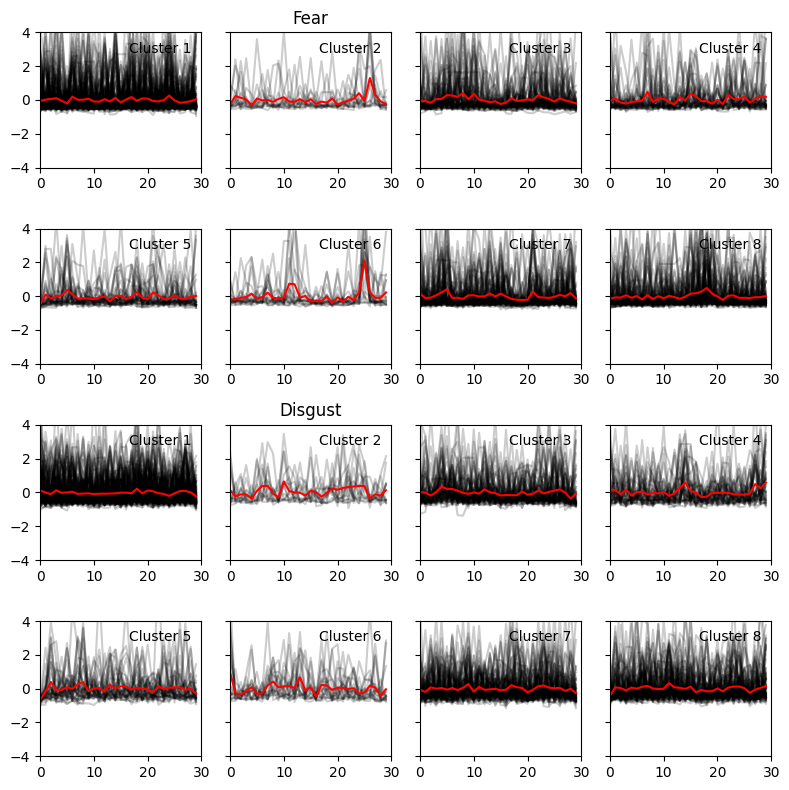

In [171]:
sz = X_train.shape[1]

# Euclidean k-means
# print("Euclidean k-means")


# plt.figure()
# plt.title(sentiment_desc)
plt.subplots(len(sentiments) * 2, 4, sharey=True, figsize=(len(sentiments) * 4, 8))

for sentiment_i in range(len(sentiments)):
    for yi in range(n_clusters):
        plt.subplot(len(sentiments) * 2, 4, sentiment_i * 8 + yi + 1)
        for xx in X_train[y_pred == yi][:, :, sentiment_i:sentiment_i+1]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi][:, sentiment_i:sentiment_i+1].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.xticks([])
        plt.text(0.55, 0.85, 'Cluster %d' % (yi + 1),
                transform=plt.gca().transAxes)
        if yi == 1:
            plt.title(sentiments[sentiment_i].capitalize())

# # DBA-k-means
# print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)


dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           n_init=3,
                           metric="dtw",
                           max_iter_barycenter=10,
                           random_state=seed)
y_pred_dba = dba_km.fit_predict(ts_train_set_rs_1)
# for yi in range(3):
#     plt.subplot(3, 3, 4 + yi)
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("DBA $k$-means")

# # Soft-DTW-k-means
# print("Soft-DTW k-means")
# sdtw_km = TimeSeriesKMeans(n_clusters=3,
#                            metric="softdtw",
#                            metric_params={"gamma": .01},
#                            random_state=seed)
# y_pred = sdtw_km.fit_predict(X_train)

# for yi in range(3):
#     plt.subplot(3, 3, 7 + yi)
#     for xx in X_train[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()


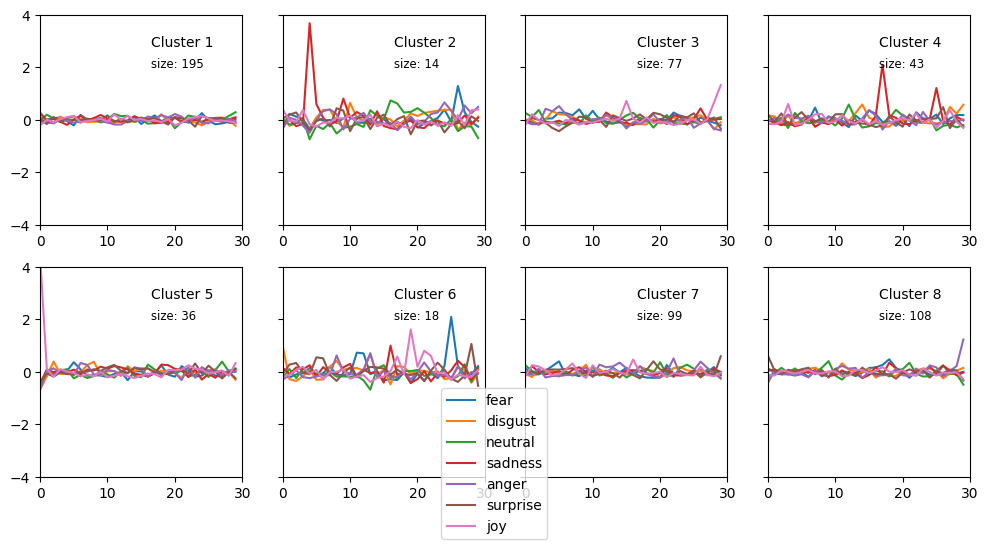

In [189]:
sentiments = list(movie_emots.columns[0:7])

def plot_clusters(X, y_pred, centers):
    sz = X.shape[1]
    fig, _ = plt.subplots(2, 4, sharey=True, figsize=(12, 6))
    labels = None

    for yi in range(n_clusters):
        ax = plt.subplot(2, 4, yi + 1)
        for sentiment_i in range(len(sentiments)):
            plt.plot(centers[yi][:, sentiment_i:sentiment_i+1].ravel(), label=sentiments[sentiment_i])
        plt.xlim(0, sz)
        plt.ylim(-1, 1)
        plt.xticks([])
        plt.text(0.1, 0.15, 'Cluster %d' % (yi + 1),
            transform=plt.gca().transAxes)
        count = len(X[y_pred == yi])
        plt.text(0.1, 0.05, 'size: %d' % count,
            transform=plt.gca().transAxes, fontsize='small')
        if yi == 0:
            _, labels = ax.get_legend_handles_labels()

    fig.legend(labels=labels, loc="upper center", ncols=len(sentiments))

plot_clusters(ts_train_set_rs_1, y_pred, km.cluster_centers_)

In [172]:
meta.loc[mids[y_pred == 1]]

,title,year,rating,no. votes,genres
movie_id,,,,,
m139,mr. smith goes to washington,1939,8.4,33984.0,['drama']
m182,the sixth sense,1999,8.2,244162.0,['drama' 'mystery' 'thriller']
m189,spider-man,2002,7.4,169898.0,['action' 'adventure' 'fantasy' 'sci-fi' 'acti...
m323,die hard,1988,8.3,185430.0,['action' 'crime' 'thriller']
m379,halloween,1978,7.9,64690.0,['horror' 'thriller']
m396,i walked with a zombie,1943,7.3,3420.0,['horror']
m404,jaws 3-d,1983,3.3,12839.0,['thriller']
m414,king kong,2005,7.6,134187.0,['adventure' 'drama' 'romance']
m492,who framed roger rabbit,1988,7.6,54375.0,['animation' 'comedy' 'crime' 'family' 'fantas...
